## Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn import metrics

In [3]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import OneHotEncoder
import pickle

In [4]:
from lib_model_cluster import showTestCluster, showTestKMean

In [5]:
data_original = pd.read_csv("data_preprocessing/data_final.csv", index_col=0)
data_original.shape

(707, 11)

## Check Outlier

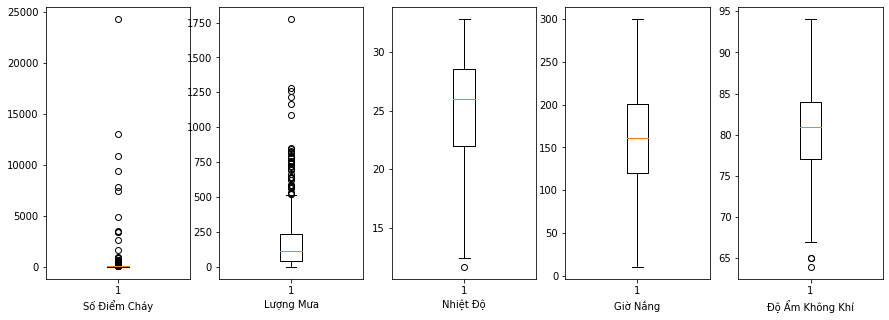

In [6]:
plt.figure(figsize=(15,5))
# ----------------
plt.subplot(1,5,1)
plt.boxplot(
    data_original.So_Diem_Chay
)
plt.xlabel('Số Điểm Cháy')
# ----------------
plt.subplot(1,5,2)
plt.boxplot(
    data_original.Rainfull
)
plt.xlabel('Lượng Mưa')
# ----------------
plt.subplot(1,5,3)
plt.boxplot(
    data_original.Air_Temperature
)
plt.xlabel('Nhiệt Độ')
# ----------------
plt.subplot(1,5,4)
plt.boxplot(
    data_original.Sunshine
)
plt.xlabel('Giờ Nắng')
# ----------------
plt.subplot(1,5,5)
plt.boxplot(
    data_original.Air_Humidity
)
plt.xlabel('Độ Ẩm Không Khí')
# ----------------
plt.show()

Cả 5 feature số điểm cháy, lượng mưa, nhiệt độ, độ ẫm không khí đều có outlier, vì vậy sẽ dùng RobustScaler để scale dữ liệu.

## Function

In [7]:
def checkComponentWSSE(data):
    scale = RobustScaler()
    data_scale = scale.fit_transform(data)
    length_columns = data.shape[1]
    dict_df = {}
    for col in range(0, length_columns):
        dict_df[col] = data_scale[: , col]
    df = pd.DataFrame(dict_df)
    for number in range(0, length_columns):
        columns = list(df.columns)
        col = columns.pop(number)
        df_sub = df[columns]
        showTestCluster(df_sub, 10, 'Remove: ' + data_before_2017.columns[col])

In [8]:
def buildModel(data, k):
    preprocess = make_column_transformer(
        (RobustScaler(), data.columns),
    )
    pipeline = make_pipeline(
        preprocess,
        KMeans(n_clusters=k, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    )
    return pipeline.fit(data)

In [9]:
def showCorr(title, data_original):
    tuple_name = set(
        data_original.Name  
    )
    columns = [
        'Ten Tinh', 
        'So_Diem_Chay VS Sunshine', 
        'So_Diem_Chay VS Air_Humidity', 
        'So_Diem_Chay VS Air_Temperature', 
        'So_Diem_Chay VS Rainfull', 
    ]
    df_corr = pd.DataFrame(columns=columns)
    for name in tuple_name:
        df = data_original[data_original.Name == name]
        new_row = pd.Series(
            data = {
                columns[0]: name,
                columns[1]: df.So_Diem_Chay.corr(df.Sunshine),
                columns[2]: df.So_Diem_Chay.corr(df.Air_Humidity),
                columns[3]: df.So_Diem_Chay.corr(df.Air_Temperature),
                columns[4]: df.So_Diem_Chay.corr(df.Rainfull)
            }
        )
        df_corr = df_corr.append(new_row, ignore_index=True)
    df_corr_show = df_corr.set_index('Ten Tinh')
    plt.figure(figsize=(10, 2))
    sb.heatmap(
        df_corr_show.T,
        annot=True,
        vmax=1,
        vmin=-1,
        fmt='0.1f',
        cmap='coolwarm'
    )
    plt.title(title + ': Mối quan hệ giữa các chỉ số thời tiết với số Điểm cháy qua các tỉnh', fontweight='bold', fontsize=14)
    plt.show()

## Split By Year

In [10]:
df_group_before_2017 = data_original[data_original.Nam < 2017].groupby(['Name', 'Ma_Tinh']).mean().reset_index()
data_before_2017 = df_group_before_2017[['So_Diem_Chay','Sunshine','Air_Humidity','Air_Temperature','Rainfull']]
# ------------
df_group_after_2017 = data_original[data_original.Nam >= 2017].groupby(['Name', 'Ma_Tinh']).mean().reset_index()
data_after_2017 = df_group_after_2017[['So_Diem_Chay','Sunshine','Air_Humidity','Air_Temperature','Rainfull']]

Vì khi phân tích số điểm cháy chúng ta đã thấy có sự tăng mạnh vào trước và sau năm 2017. Nên sẽ có 2 model cho trước và sau năm 2017.

## Build Model

### Before 2017

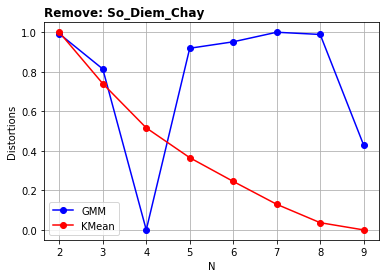

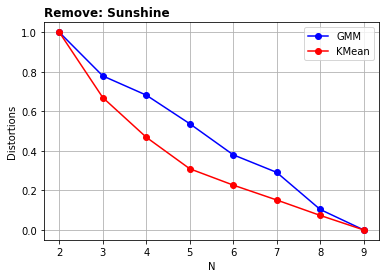

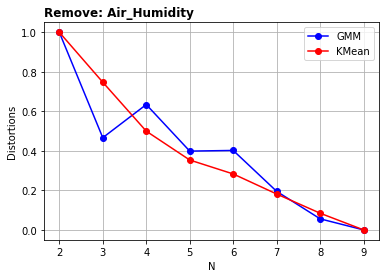

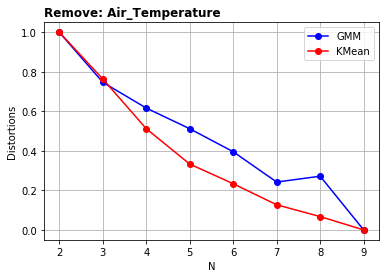

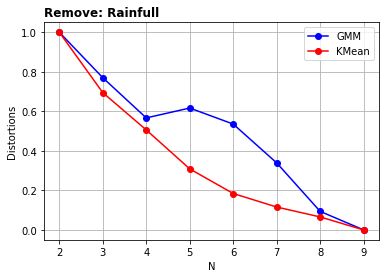

In [11]:
checkComponentWSSE(data_before_2017)

Từ những biểu đồ trên ta có thể thấy : 
<blockquote>
    - Model K-Mean chạy ỗn định hơn GMM trong trường hợp này. <br>
    - Feature 'Số Điểm cháy' có ảnh hưởng mạnh đến việc phân nhóm. <br>
    - Những feature còn lại sẽ có giá trị phân tích. <br>
    - Sẽ có 3 nhóm tối ưu trong trường hợp này.
</blockquote>

In [12]:
model_before_2017 = buildModel(data_before_2017, 4)
data_before_2017 = data_before_2017.assign(
    Ma_Tinh = df_group_before_2017.Ma_Tinh,
    Ten_Tinh = df_group_before_2017.Name,
    Group = model_before_2017.predict(data_before_2017)
)
data_before_2017

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
0,2.700000,191.695000,79.300000,28.240000,153.620000,96.0,Cà Mau,3
1,11.803030,167.036364,85.484848,25.650000,220.980303,46.0,Huế,1
2,1.111111,96.011111,73.333333,20.266667,24.055556,1.0,Hà Nội,2
3,78.200000,169.922222,79.044444,19.571111,134.013333,12.0,Lai Châu,0
4,6.142857,143.440476,80.880952,26.892857,200.395238,36.0,Nam Định,1
5,87.980392,174.686275,78.686275,20.586275,88.849020,14.0,Sơn La,0
6,11.279070,122.406977,80.930233,23.567442,115.272093,8.0,Tuyên Quang,1
7,14.714286,138.521429,80.309524,26.526190,239.754762,84.0,Vinh,1
8,2.720000,220.496000,76.560000,27.880000,70.412000,77.0,Vũng Tàu,3
9,9.857143,173.842857,80.000000,27.347619,315.923810,48.0,Đà Nẵng,1


In [13]:
display(
    data_before_2017[data_before_2017.Group == 0],
    data_before_2017[data_before_2017.Group == 1],
    data_before_2017[data_before_2017.Group == 2],
    data_before_2017[data_before_2017.Group == 3]
)

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
3,78.200000,169.922222,79.044444,19.571111,134.013333,12.0,Lai Châu,0
5,87.980392,174.686275,78.686275,20.586275,88.849020,14.0,Sơn La,0


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
1,11.803030,167.036364,85.484848,25.650000,220.980303,46.0,Huế,1
4,6.142857,143.440476,80.880952,26.892857,200.395238,36.0,Nam Định,1
6,11.279070,122.406977,80.930233,23.567442,115.272093,8.0,Tuyên Quang,1
7,14.714286,138.521429,80.309524,26.526190,239.754762,84.0,Vinh,1
9,9.857143,173.842857,80.000000,27.347619,315.923810,48.0,Đà Nẵng,1


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
2,1.111111,96.011111,73.333333,20.266667,24.055556,1.0,Hà Nội,2


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
0,2.70,191.695,79.30,28.24,153.620,96.0,Cà Mau,3
8,2.72,220.496,76.56,27.88,70.412,77.0,Vũng Tàu,3


Từ 3 bảng trên, có thể phân làm 3 nhóm với đặc tính như sau:
<blockquote>
    - Nhóm cháy cao (0) : gồm tỉnh Lai Châu, Sơn La với số điểm cháy trung bình là hằng tháng là 78,2 và 87,98 điểm. <br>
    - Nhóm cháy vừa (1) : gồm tỉnh Huế (11,8 điểm), Nam Định (6.1 điểm), Tuyên Quang (11,27 điểm), Vinh (14,7 điểm), Đà Nẵng (9,8 điểm). <br>
    - Nhóm cháy thấp (3): gồm Cà Mau (2,7 điểm), Vũng Tàu (2.72 điểm). <br>
    - Nhóm cháy rất thấp (2): Hà Nội (1,1 điềm).
</blockquote>

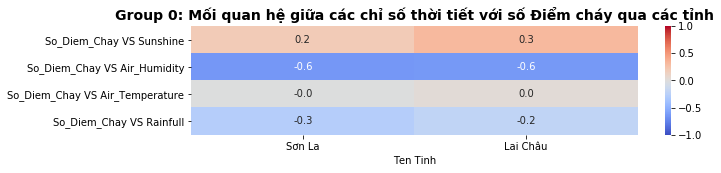

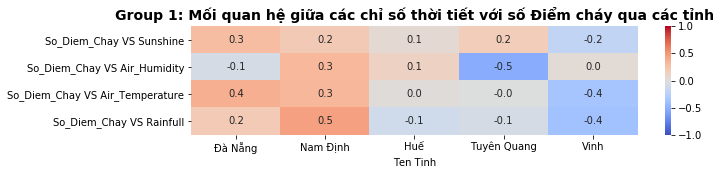

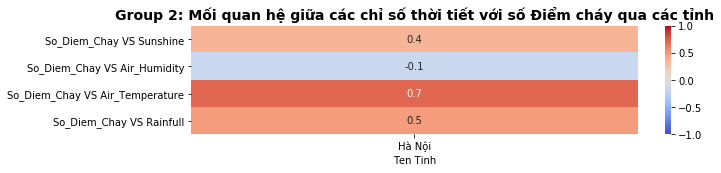

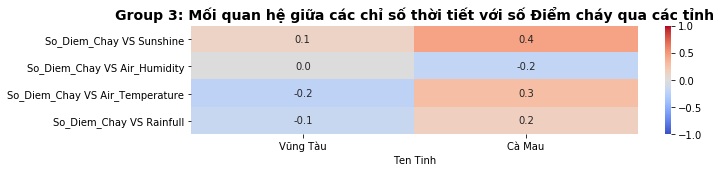

None

None

None

None

In [14]:
dict_group = {}
for index in range(0, data_before_2017.shape[0]):
    key = data_before_2017[['Ma_Tinh', 'Group']].iloc[index, 0]
    value = data_before_2017[['Ma_Tinh', 'Group']].iloc[index, 1]
    dict_group[key] = value
data_show = data_original[
    data_original.Nam < 2017
].assign(
    Group = data_original.Ma_Tinh.map(lambda x: dict_group[x])
)
# ----------------
data_show.to_csv('data_model/data_before_2017.csv')
# ----------------
display(
    showCorr('Group 0', data_show[data_show.Group == 0]),
    showCorr('Group 1', data_show[data_show.Group == 1]),
    showCorr('Group 2', data_show[data_show.Group == 2]),
    showCorr('Group 3', data_show[data_show.Group == 3]),
)

Từ hình trên có thể thấy, trước năm 2017, ngoài Hà Nội với số điểm cháy có mối tương quan thuận mạnh với nhiệt độ không khí, thì những chỉ số thời tiết có mối tương quan không đủ mạnh tới số điểm cháy của các tỉnh.

### After 2017

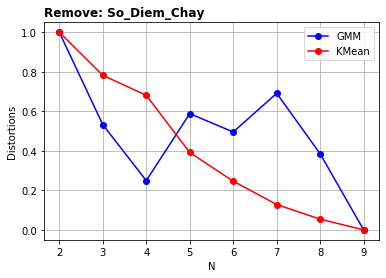

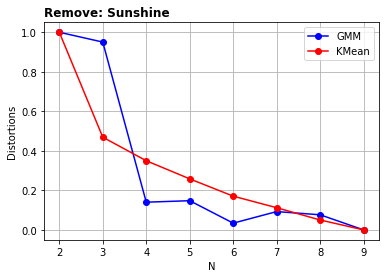

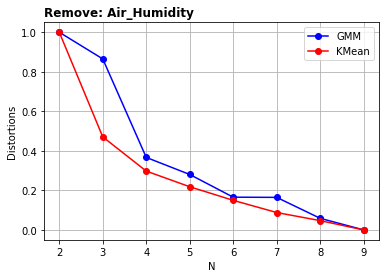

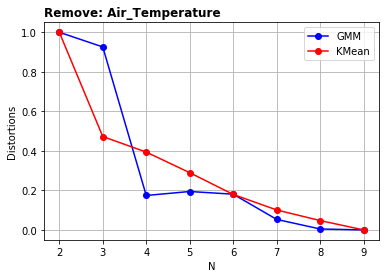

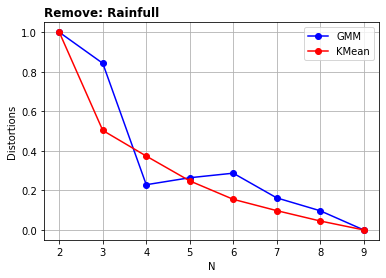

In [15]:
checkComponentWSSE(data_after_2017)

Từ những biểu đồ trên ta có thể thấy : 
<blockquote>
    - Model K-Mean chạy ỗn định hơn GMM trong trường hợp này. <br>
    - Feature 'Số Điểm cháy' có ảnh hưởng mạnh đến việc phân nhóm. <br>
    - Những feature còn lại sẽ có giá trị phân tích. <br>
    - Sẽ có 3 nhóm tối ưu trong trường hợp này.
</blockquote>

In [16]:
model_after_2017 = buildModel(data_after_2017, 3)
data_after_2017 = data_after_2017.assign(
    Ma_Tinh = df_group_before_2017.Ma_Tinh,
    Ten_Tinh = df_group_after_2017.Name,
    Group = model_after_2017.predict(data_after_2017)
)
data_after_2017

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
0,68.343750,166.146875,81.093750,28.043750,191.675000,96.0,Cà Mau,1
1,142.333333,173.348485,86.121212,25.966667,235.896970,46.0,Huế,1
2,25.843750,107.015625,75.468750,25.812500,145.325000,1.0,Hà Nội,1
3,919.527778,159.291667,83.805556,20.211111,239.352778,12.0,Lai Châu,0
4,11.413793,125.731034,82.413793,25.496552,169.686207,36.0,Nam Định,1
5,1810.916667,176.027778,78.277778,22.011111,109.358333,14.0,Sơn La,2
6,113.250000,125.655556,81.500000,24.511111,148.958333,8.0,Tuyên Quang,1
7,50.000000,139.914286,82.142857,25.557143,200.160714,84.0,Vinh,1
8,80.870968,217.722581,78.193548,28.232258,140.274194,77.0,Vũng Tàu,1
9,32.344828,182.417241,79.241379,27.096552,224.862069,48.0,Đà Nẵng,1


In [17]:
display(
    data_after_2017[data_after_2017.Group == 0],
    data_after_2017[data_after_2017.Group == 1],
    data_after_2017[data_after_2017.Group == 2]
)

,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
3,919.527778,159.291667,83.805556,20.211111,239.352778,12.0,Lai Châu,0


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
0,68.343750,166.146875,81.093750,28.043750,191.675000,96.0,Cà Mau,1
1,142.333333,173.348485,86.121212,25.966667,235.896970,46.0,Huế,1
2,25.843750,107.015625,75.468750,25.812500,145.325000,1.0,Hà Nội,1
4,11.413793,125.731034,82.413793,25.496552,169.686207,36.0,Nam Định,1
6,113.250000,125.655556,81.500000,24.511111,148.958333,8.0,Tuyên Quang,1
7,50.000000,139.914286,82.142857,25.557143,200.160714,84.0,Vinh,1
8,80.870968,217.722581,78.193548,28.232258,140.274194,77.0,Vũng Tàu,1
9,32.344828,182.417241,79.241379,27.096552,224.862069,48.0,Đà Nẵng,1


,So_Diem_Chay,Sunshine,Air_Humidity,Air_Temperature,Rainfull,Ma_Tinh,Ten_Tinh,Group
5,1810.916667,176.027778,78.277778,22.011111,109.358333,14.0,Sơn La,2


Từ 3 bảng trên, có thể phân làm 3 nhóm với đặc tính như sau:
<blockquote>
    - Nhóm cháy cao (2) : gồm tỉnh Sơn La với số điểm cháy trung bình là hằng tháng là 1810.9 điểm. <br>
    - Nhóm cháy vừa (0) : gồm tỉnh Lai Châu với số điểm cháy trung bình là hằng tháng là 919.5 điểm.<br>
    - Nhóm cháy thấp (1) : gồm Cà Mau (68.34), Huế (142.33), Hà Nội (25.84), Nam Định (11.41), Tuyên Quang (113.25), Vinh(50), Vũng Tàu (80.87), Đà Nẵng (32.34)
</blockquote>
Có sự chuyển dịch của 2 tỉnh Hà Nội, Vũng Tàu từ nhóm nguy cơ 'cháy vừa' qua nhóm 'cháy thấp', với số điểm cháy cháy tăng lên.

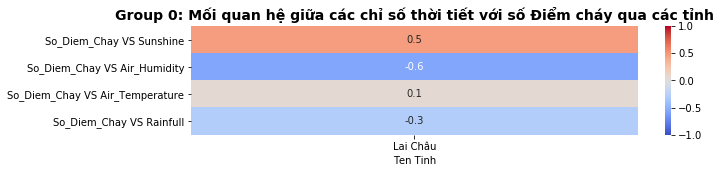

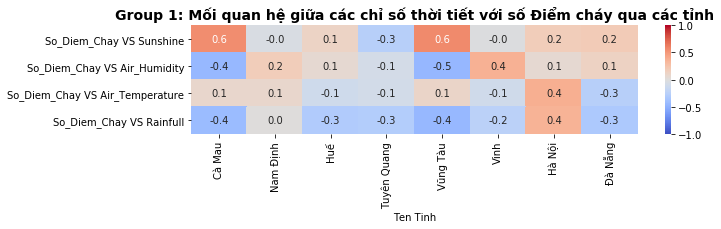

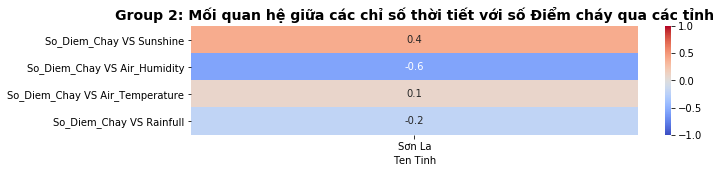

None

None

None

In [18]:
dict_group = {}
for index in range(0, data_after_2017.shape[0]):
    key = data_after_2017[['Ma_Tinh', 'Group']].iloc[index, 0]
    value = data_after_2017[['Ma_Tinh', 'Group']].iloc[index, 1]
    dict_group[key] = value
data_show = data_original[
    data_original.Nam >= 2017
].assign(
    Group = data_original.Ma_Tinh.map(lambda x: dict_group[x])
)
# ----------------
data_show.to_csv('data_model/data_after_2017.csv')
# ----------------
display(
    showCorr('Group 0', data_show[data_show.Group == 0]),
    showCorr('Group 1', data_show[data_show.Group == 1]),
    showCorr('Group 2', data_show[data_show.Group == 2])
)

Từ hình trên có thể thấy, sau năm 2017, các chỉ số thời tiết có mối tương quan không đủ mạnh tới số điểm cháy của các tỉnh.

## Save Model Cluster

In [19]:
filename_before_2017 = 'save_model/model_cluster_before_2017.sav'
pickle.dump(model_before_2017, open(filename_before_2017, 'wb'))
# -------
filename_after_2017 = 'save_model/model_cluster_after_2017.sav'
pickle.dump(model_after_2017, open(filename_after_2017, 'wb'))

In [20]:
loaded_model_before_2017 = pickle.load(open(filename_before_2017, 'rb'))
# -------
loaded_model_after_2017 = pickle.load(open(filename_after_2017, 'rb'))

In [21]:
print(
    'Group',
    loaded_model_before_2017.predict(
        data_before_2017.iloc[1, [0,1,2,3,4]].to_frame().T
    )[0]
)

Group 1


In [22]:
print(
    'Group',
    loaded_model_after_2017.predict(
        data_after_2017.iloc[1, [0,1,2,3,4]].to_frame().T
    )[0]
)

Group 1
